In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
!export OPENAI_API_KEY="4"


In [2]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [282]:
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict

In [63]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_from_summary('player_valuation', g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]), 
    resources_delta = (final_resources-initial_resources)[0]
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)

    for i in (game_name, models, outcomes,  resources_delta, social_behavior):
        print(i.shape)
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2"])

    return df
      


In [64]:

PAIRS_OF_AGENTS = ["gpt-4-1106-preview", "gpt-3.5-turbo-1106", "claude-2", "claude-2.1"], ["gpt-4-1106-preview", "gpt-3.5-turbo-1106", "claude-2", "claude-2.1"]
PAIRS_OF_AGENTS = [[x, y] for x, y in itertools.product(*PAIRS_OF_AGENTS) if x != y]


In [180]:
def collect_and_plot_heatmap(df_, AGENTS, AGENTS_CLEAN, PAIRS_OF_AGENTS, debug=False):

    dici = defaultdict(list)
    
    for index, row in df_.iterrows():
        m1 = row["model_1"]
        m2 = row["model_2"]
        if row["resource_delta_1"] > row["resource_delta_2"]:
            dici[f"{m1}#{m2}"].append(m1)
        elif row["resource_delta_1"] < row["resource_delta_2"]:
            dici[f"{m1}#{m2}"].append(m2)
        else:
            dici[f"{m1}#{m2}"].append("draw")
    
    combined = defaultdict(list)
    seen = set()
    
    for a, b in PAIRS_OF_AGENTS:
        if f"{a}#{b}" in seen or f"{b}#{a}" in seen:
            continue
        else:
            seen.add(f"{a}#{b}")
            seen.add(f"{b}#{a}")
            
        d = dict(Counter(dici[f"{a}#{b}"] + dici[f"{b}#{a}"]))
        
        sm = sum(d.values())

        # avoding errors cuz div by 0
        if b not in d:
            d[b] = 0.000001
        if a not in d:
            d[a] = 0.000001
        
        combined[a+b] = d[a]/(d[a]+d[b])
        combined[b+a] = d[b]/(d[a]+d[b])
        if debug:
            print("----------------------------------")
            print(a,b)
            print()
            for i, j in d.items(): 
                score = round(j/sm, 2)
                print(f"\tWinRate {i}: {score}")

    l2 = []
    for agent in AGENTS:
        l = []
        for agent2 in AGENTS:
            if agent+agent2 in combined:
                l.append(combined[agent+agent2])
            elif agent2+agent in combined:
                l.append(combined[agent2+agent])
            else:
                l.append(1)
        l2.append(l)
    return np.array(l2)


### Ultimatum Base

In [176]:
%%capture
log_dir = "../experiments/section_one/.logs/ultimatum_multi_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

df = compute_game_summary(game_states)
df["resource_delta_1"] = 100 + df["resource_delta_1"]

In [177]:
AGENTS = ["gpt-4-1106-preview", "gpt-3.5-turbo-1106", "claude-2", "claude-2.1"]
AGENTS_CLEAN = ["GPT-4", "GPT-3.5", "Claude-2", "Claude-2.1"]
PAIRS_OF_AGENTS = [[x, y] for x, y in itertools.product(AGENTS, AGENTS) if x != y]


<AxesSubplot:>

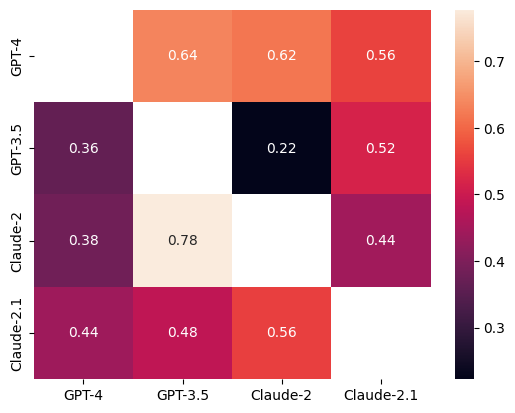

In [181]:
l2 = collect_and_plot_heatmap(df, AGENTS, AGENTS_CLEAN, PAIRS_OF_AGENTS)
mask = np.eye(l2.shape[0], dtype=bool)

sns.heatmap(l2, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN, xticklabels=AGENTS_CLEAN)

### Trading Base

In [182]:
%%capture
log_dir = "../experiments/section_one/.logs/trading_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

df = compute_game_summary(game_states)

In [183]:
AGENTS = ["gpt-4-1106-preview", "gpt-3.5-turbo-1106", "claude-2", "claude-2.1"]
AGENTS_CLEAN = ["GPT-4", "GPT-3.5", "Claude-2", "Claude-2.1"]
PAIRS_OF_AGENTS = [[x, y] for x, y in itertools.product(AGENTS, AGENTS) if x != y]

<AxesSubplot:>

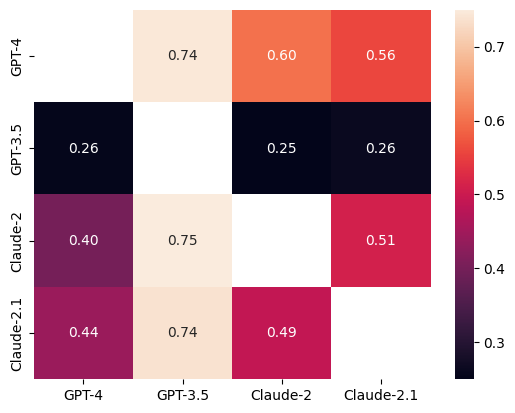

In [186]:
l2 = collect_and_plot_heatmap(df, AGENTS, AGENTS_CLEAN, PAIRS_OF_AGENTS)
mask = np.eye(l2.shape[0], dtype=bool)

sns.heatmap(l2, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN, xticklabels=AGENTS_CLEAN)

### BuySell

In [187]:
%%capture
log_dir = "../experiments/section_one/.logs/buysell_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

df = compute_game_summary(game_states)

In [188]:
AGENTS = ["gpt-4-1106-preview", "gpt-3.5-turbo-1106", "claude-2", "claude-2.1"]
AGENTS_CLEAN = ["GPT-4", "GPT-3.5", "Claude-2", "Claude-2.1"]
PAIRS_OF_AGENTS = [[x, y] for x, y in itertools.product(AGENTS, AGENTS) if x != y]

<AxesSubplot:>

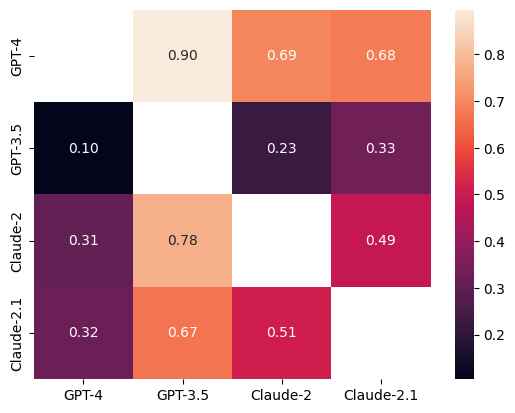

In [189]:
l2 = collect_and_plot_heatmap(df, AGENTS, AGENTS_CLEAN, PAIRS_OF_AGENTS)
mask = np.eye(l2.shape[0], dtype=bool)

sns.heatmap(l2, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN, xticklabels=AGENTS_CLEAN)

# Social Behaviors

## Ultimatum


Hostile is best, but is also high risk high reward.

In [88]:
SINGLE_BEHAVIORS = ["",
                    "\nYou are cunning and sly in your plan to get more than your opponent. Humiliate your opponent as much as possible. Insult them.",
                    "\nYou must fake being desperate. Supplicate and beg to get more dollars."]

mapper_of_behaviors = {}
for i, j in zip(SINGLE_BEHAVIORS, ["Default", "Hostile", "Begger"]):
    mapper_of_behaviors[i] = j

In [204]:
%%capture
log_dir = "../experiments/section_two/.logs/social_behaviors_ultimatum/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

df = compute_game_summary(game_states)
def update_func(x):
    if x == 0:
        return 0
    else:
        return x+100

df["resource_delta_1"] = df["resource_delta_1"].apply(update_func)

In [205]:
df["social_2"] = df["social_2"].replace(mapper_of_behaviors)
df["model_2"] = df["model_2"] + " " + df["social_2"]

In [207]:
AGENTS = list(set(df.model_1.unique().tolist() + df.model_2.unique().tolist()))
PAIRS_OF_AGENTS = [[x, y] for x, y in itertools.product(AGENTS,AGENTS) if x != y]


In [208]:
AGENTS

['gpt-4-1106-preview Begger',
 'gpt-4-1106-preview',
 'gpt-4-1106-preview Default',
 'gpt-4-1106-preview Hostile']

<AxesSubplot:>

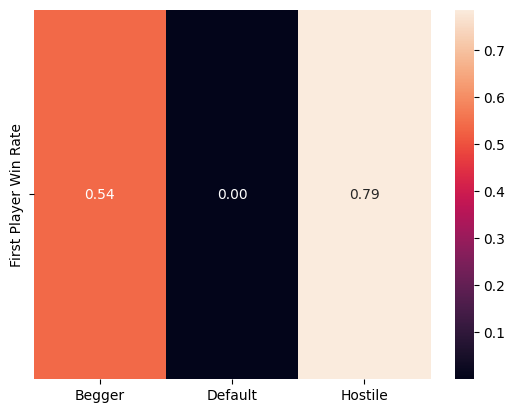

In [224]:
l2 = collect_and_plot_heatmap(df, AGENTS, AGENTS_CLEAN, PAIRS_OF_AGENTS)
l2 = l2[:,1]
indices_to_keep = [0, 2, 3]
l2 = l2[indices_to_keep]
l2 = np.array([l2])

sns.heatmap(l2, annot=True, fmt=".2f", yticklabels=["First Player Win Rate"], xticklabels=["Begger", "Default", "Hostile"])

In [106]:
AGENTS

['gpt-4-1106-preview']

## BuySell

In [249]:
SINGLE_BEHAVIORS = ["",
                    "\nYou are cunning and sly in your plan to spend less ZUP. Humiliate your opponent as much as possible. Insult them.",
                    "\nYou must fake being desperate. Supplicate and beg to spend less ZUP."]
mapper_of_behaviors = {}
for i, j in zip(SINGLE_BEHAVIORS, ["Default", "Hostile", "Begger"]):
    mapper_of_behaviors[i] = j

In [250]:
%%capture
log_dir = "../experiments/section_two/.logs/social_behaviors_buy_sell/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

df = compute_game_summary(game_states)


In [261]:
df.columns

Index(['game_name', 'model_1', 'model_2', 'outcome_1', 'outcome_2',
       'resource_delta_1', 'resource_delta_2', 'social_1', 'social_2'],
      dtype='object')

In [251]:
df["social_2"] = df["social_2"].replace(mapper_of_behaviors)
df["model_2"] = df["model_2"] + " " + df["social_2"]

In [267]:
df["resource_delta_2"] = df["resource_delta_2"].astype(int)

In [270]:
pd.DataFrame(df.groupby(["model_1", "social_2"])["resource_delta_2"].mean())

resource_delta_2
model_1            social_2                  
gpt-4-1106-preview Begger           18.800000
                   Default          13.733333
                   Hostile          21.533333

### Trading Social

In [273]:
SINGLE_BEHAVIORS = ["",
                    "\nYou are cunning and sly in your plan to get more resources. Humiliate your opponent as much as possible. Insult them.",
                    "\nYou must fake being desperate. Supplicate and beg to get more resources."]

mapper_of_behaviors = {}
for i, j in zip(SINGLE_BEHAVIORS, ["Default", "Hostile", "Begger"]):
    mapper_of_behaviors[i] = j

In [272]:
%%capture
log_dir = "../experiments/section_two/.logs/social_behaviors_trading/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

df = compute_game_summary(game_states)


In [274]:
df["social_2"] = df["social_2"].replace(mapper_of_behaviors)
df["model_2"] = df["model_2"] + " " + df["social_2"]

In [281]:
pd.DataFrame(df.groupby(["model_1", "social_2"])["resource_delta_2"].mean())

resource_delta_2
model_1            social_2                 
gpt-4-1106-preview Begger              2.065
                   Default              1.05
                   Hostile             2.675